# Ordinary Least Squares

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

np.random.seed(9876789)

## OLS estimation

Artificial data:

In [3]:
nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x ** 2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

Our model needs an intercept so we add a column of 1s:

In [4]:
X = sm.add_constant(X)
y = np.dot(X, beta) + e

Fit and summary:

In [5]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.020e+06
Date:                Wed, 28 Aug 2024   Prob (F-statistic):          2.83e-239
Time:                        14:08:46   Log-Likelihood:                -146.51
No. Observations:                 100   AIC:                             299.0
Df Residuals:                      97   BIC:                             306.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3423      0.313      4.292      0.0

Quantities of interest can be extracted directly from the fitted model. Type ``dir(results)`` for a full list. Here are some examples:  

In [6]:
print("Parameters: ", results.params)
print("R2: ", results.rsquared)

Parameters:  [ 1.34233516 -0.04024948 10.01025357]
R2:  0.9999879365025871


## OLS non-linear curve but linear in parameters

We simulate artificial data with a non-linear relationship between x and y:

In [7]:
nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x - 5) ** 2, np.ones(nsample)))
beta = [0.5, 0.5, -0.02, 5.0]

y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

Fit and summary:

In [8]:
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     211.8
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           6.30e-27
Time:                        14:08:46   Log-Likelihood:                -34.438
No. Observations:                  50   AIC:                             76.88
Df Residuals:                      46   BIC:                             84.52
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4687      0.026     17.751      0.0

Extract other quantities of interest:

In [9]:
print("Parameters: ", res.params)
print("Standard errors: ", res.bse)
print("Predicted values: ", res.predict())

Parameters:  [ 0.46872448  0.48360119 -0.01740479  5.20584496]
Standard errors:  [0.02640602 0.10380518 0.00231847 0.17121765]
Predicted values:  [ 4.77072516  5.22213464  5.63620761  5.98658823  6.25643234  6.44117491
  6.54928009  6.60085051  6.62432454  6.6518039   6.71377946  6.83412169
  7.02615877  7.29048685  7.61487206  7.97626054  8.34456611  8.68761335
  8.97642389  9.18997755  9.31866582  9.36587056  9.34740836  9.28893189
  9.22171529  9.17751587  9.1833565   9.25708583  9.40444579  9.61812821
  9.87897556 10.15912843 10.42660281 10.65054491 10.8063004  10.87946503
 10.86825119 10.78378163 10.64826203 10.49133265 10.34519853 10.23933827
 10.19566084 10.22490593 10.32487947 10.48081414 10.66779556 10.85485568
 11.01006072 11.10575781]


Draw a plot to compare the true relationship to OLS predictions. Confidence intervals around the predictions are built using the ``wls_prediction_std`` command.

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

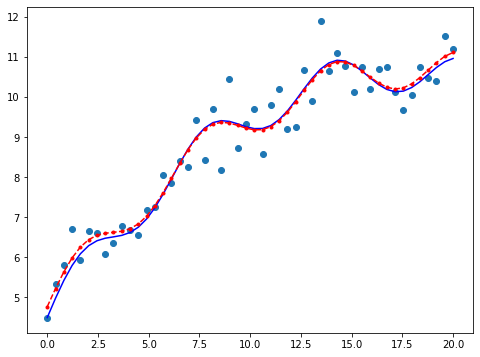

In [10]:
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y, "o", label="data")
ax.plot(x, y_true, "b-", label="True")
ax.plot(x, res.fittedvalues, "r--.", label="OLS")
ax.plot(x, iv_u, "r--")
ax.plot(x, iv_l, "r--")
ax.legend(loc="best")

## OLS with dummy variables

We generate some artificial data. There are 3 groups which will be modelled using dummy variables. Group 0 is the omitted/benchmark category.

In [ ]:
nsample = 50
groups = np.zeros(nsample, int)
groups[20:40] = 1
groups[40:] = 2
# dummy = (groups[:,None] == np.unique(groups)).astype(float)

dummy = pd.get_dummies(groups).values
x = np.linspace(0, 20, nsample)
# drop reference category
X = np.column_stack((x, dummy[:, 1:]))
X = sm.add_constant(X, prepend=False)

beta = [1.0, 3, -3, 10]
y_true = np.dot(X, beta)
e = np.random.normal(size=nsample)
y = y_true + e

Inspect the data:

In [ ]:
print(X[:5, :])
print(y[:5])
print(groups)
print(dummy[:5, :])

Fit and summary:

In [ ]:
res2 = sm.OLS(y, X).fit()
print(res2.summary())

Draw a plot to compare the true relationship to OLS predictions:

In [ ]:
pred_ols2 = res2.get_prediction()
iv_l = pred_ols2.summary_frame()["obs_ci_lower"]
iv_u = pred_ols2.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y, "o", label="Data")
ax.plot(x, y_true, "b-", label="True")
ax.plot(x, res2.fittedvalues, "r--.", label="Predicted")
ax.plot(x, iv_u, "r--")
ax.plot(x, iv_l, "r--")
legend = ax.legend(loc="best")

## Joint hypothesis test

### F test

We want to test the hypothesis that both coefficients on the dummy variables are equal to zero, that is, $R \times \beta = 0$. An F test leads us to strongly reject the null hypothesis of identical constant in the 3 groups:

In [ ]:
R = [[0, 1, 0, 0], [0, 0, 1, 0]]
print(np.array(R))
print(res2.f_test(R))

You can also use formula-like syntax to test hypotheses

In [ ]:
print(res2.f_test("x2 = x3 = 0"))

### Small group effects

If we generate artificial data with smaller group effects, the T test can no longer reject the Null hypothesis: 

In [ ]:
beta = [1.0, 0.3, -0.0, 10]
y_true = np.dot(X, beta)
y = y_true + np.random.normal(size=nsample)

res3 = sm.OLS(y, X).fit()

In [ ]:
print(res3.f_test(R))

In [ ]:
print(res3.f_test("x2 = x3 = 0"))

### Multicollinearity

The Longley dataset is well known to have high multicollinearity. That is, the exogenous predictors are highly correlated. This is problematic because it can affect the stability of our coefficient estimates as we make minor changes to model specification. 

In [ ]:
from statsmodels.datasets.longley import load_pandas

y = load_pandas().endog
X = load_pandas().exog
X = sm.add_constant(X)

Fit and summary:

In [ ]:
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print(ols_results.summary())

#### Condition number

One way to assess multicollinearity is to compute the condition number. Values over 20 are worrisome (see Greene 4.9). The first step is to normalize the independent variables to have unit length: 

In [ ]:
norm_x = X.values
for i, name in enumerate(X):
    if name == "const":
        continue
    norm_x[:, i] = X[name] / np.linalg.norm(X[name])
norm_xtx = np.dot(norm_x.T, norm_x)

Then, we take the square root of the ratio of the biggest to the smallest eigen values. 

In [ ]:
eigs = np.linalg.eigvals(norm_xtx)
condition_number = np.sqrt(eigs.max() / eigs.min())
print(condition_number)

#### Dropping an observation

Greene also points out that dropping a single observation can have a dramatic effect on the coefficient estimates: 

In [ ]:
ols_results2 = sm.OLS(y.iloc[:14], X.iloc[:14]).fit()
print(
    "Percentage change %4.2f%%\n"
    * 7
    % tuple(
        [
            i
            for i in (ols_results2.params - ols_results.params)
            / ols_results.params
            * 100
        ]
    )
)

We can also look at formal statistics for this such as the DFBETAS -- a standardized measure of how much each coefficient changes when that observation is left out.

In [ ]:
infl = ols_results.get_influence()

In general we may consider DBETAS in absolute value greater than $2/\sqrt{N}$ to be influential observations

In [ ]:
2.0 / len(X) ** 0.5

In [ ]:
print(infl.summary_frame().filter(regex="dfb"))

## Overfitting

In [ ]:
X = np.random.normal(size=(n, p))
y = np.random.normal(size=(n, 1))
print(f"p/n is: {p/n if n != 0 else np.inf}")
print(f"R^2 is {sm.OLS(y, X).fit().rsquared}")
print(f"Adjusted R^2 is {sm.OLS(y, X).fit().rsquared_adj}")